In [20]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.sparse import hstack
import xgboost
import matplotlib.pyplot as pyplot

In [2]:
dt = pd.read_csv('data_redacted.tsv', sep='\t')

In [4]:
dt.head()

,title,text,url,category
0,"Don""t Mourn the Y Chromosome","The human Y chromosome may vanish one day, but...",http://discovermagazine.com/2014/nov/13-y-not,technology_science
1,Destiny: Bungie to introduce ammo pack micro-t...,Bungie is putting together plans to start sell...,http://www.ibtimes.co.uk/destiny-bungie-introd...,digital_life
2,Daruvala to race for Josef Kaufmann Racing in ...,Highly rated Jehan Daruvala will race for Jose...,http://www.thecheckeredflag.co.uk/2015/12/daru...,sports
3,Secondary tropical forests absorb carbon at hi...,Forests are an important carbon sink. While mo...,http://www.sciencedaily.com/releases/2016/02/1...,technology_science
4,This Brow Hack Will Change the Way You Fill In...,Before everyone was trying to get eyebrows on ...,http://www.popsugar.com/beauty/How-Use-Brow-Ge...,fashion_beauty_lifestyle


In [5]:
len(dt.index)

8646

## Data Preparation

### Extracting the website from the URL

I am assuming the format of the URL is fairly standard for most entries

In [7]:
dt['website'] = [url.split('/')[2] if len(url.split('/'))>2 else None for url in dt['url']]

Let's see how successful the process was

In [7]:
dt.loc[pd.isnull(dt['website'])]

,title,text,url,category,website
30,Horoscopes: Catherine Tennant looks at the wee...,Aries - March 21-April 21 The annual new moon ...,Horoscopes: Catherine Tennant looks at the wee...,fashion_beauty_lifestyle,None
2039,Revisiting the 80s from Latin funjk to smooth ...,"Any new music from Los Charly""s Orchestra caus...",Rediscovering The Big Apple,music,None
3618,​When actors such as Daniel Craig face endless...,“James Bond is a notorious ladies’ man. What p...,"Daniel Craig doesn't care about publicity, sil...",people_shows,None
3752,In the late 1960s a UN agency said tourism pro...,A team of experts from the United Nations Deve...,The history of tourism in the Maldives,travel,None
3998,Botswana is the stomping ground of safari guid...,Flying in a tiny Cessna over the Makgadikgadi ...,Botswana safari guide: Ralph Bousfield explore...,travel,None
4712,It was acceptable in the 80s. And if you’re Th...,David Hasselhoff has unveiled the music video ...,The Hoff channels 80s cheese in new music video,music,None
5772,This Christmas many of us will be planning to ...,Hosting a family Christmas should be about kee...,Planning a Stress Free Christmas Family Get To...,fashion_beauty_lifestyle,None
6860,"Last year was all about the following: kale, t...","That""s right, with the new year marking a chan...",The Top 3 Skincare Ingredients To Know For 2015,fashion_beauty_lifestyle,None


It looks like a handful or entries doesn't have the url field populated correctly

Only a small number of entries do not have a valid URL, so I could not extract the website from them

### Train-Validation split

Split the data into 2 samples, one for training and one for validation.

In [8]:
msk = np.random.rand(len(dt)) < 0.8
train = dt[msk]
val = dt[~msk]

# Model Experimentation

I will experiment with the following 3 approaches, in increasing order of complexity

1. Naive Bayes approach: extract website from URL. Predict the most common category for each website 
2. Nearest Neighbor classifier using the TF-IDF representation of the articles' text
3. Gradient Boosted Trees using TF-IDF representation and website vector.

## Model comparison

In [5]:
cat = train['category'].value_counts()
cat

fashion_beauty_lifestyle    1101
sports                       938
technology_science           841
digital_life                 597
money_business               575
news                         516
music                        459
travel                       437
culture                      429
cars_motors                  376
politics                     349
people_shows                 291
Name: category, dtype: int64

Given the nature of the task - predicting the correct category for each article - it seems reasonable to use the multiclass classification metric as the error metric to compare different models. the definition of multiclass error rate that I am using is #(wrong cases)/#(all cases). 

This is by no means the perfect metric and in a real-life situation models should be evaluated on a variety of metrics. For instance, the multiclass error rate weights equally a case where the model mistakenly predicts a category that is similar to the correct one - such as "music" and "culture" - and a case where the predicted category is very diffeerent from the correct one - such as "cars_motors" and "music". In this situation, a metric that takes into account the proximity of the options such as AUC - used for option ranking tasks - could also be beneficial. 

In addition, given the imbalanced sample distibution between categories, we might want to use macro average of the F1 score, which evaluates classifier performance over the individual classes. The assumption there is that we care about our ability to classify each category equally, but is that fair? What if most of the readers enjoy articles most popular category, and hence we care more about perfoming well in "fashion_beauty_lifestyle" than "people_show"? Since we cannot answer this question without learning about the business and product requirements, a good compromise for the sake of this exercise could be using the weighted f1 score, which takes into account the performance for each label but weight that performance by the size of the class.

## Naive Bayes

In this case, my predictor will just be a dictionary with the most popular category for each website

First, let's get the number of articles by category for each website

In [17]:
web_cat = pd.DataFrame(train.groupby(['website', 'category']).size())
web_cat = web_cat.rename(columns={0:'n'})

Here's what the category count looks like for _The Guardian_

In [145]:
web_cat.loc['www.theguardian.com']

,n
category,
cars_motors,15
culture,97
digital_life,27
fashion_beauty_lifestyle,134
money_business,44
music,53
news,67
people_shows,16
politics,52


Find the most common category for each website

In [10]:
web_main_cat = web_cat.groupby(level='website').idxmax()

Sanity check

In [13]:
web_main_cat.loc['www.theguardian.com']['n'][1]

'fashion_beauty_lifestyle'

In [11]:
#return the most common category for each website. If no website found, just return the most common category
def get_most_common_category(website):
    if website in web_main_cat.index:
        return web_main_cat.loc[website]['n'][1]
    return cat.head(1).index[0]

Let's test out the function

In [12]:
get_most_common_category('phys.org')

'technology_science'

Simply check how many times the category of each article in the validation set matches the most popular category for the website

In [13]:
naive_score = [1 if get_most_common_category(web) == cat else 0 for web, cat in zip(val['website'], val['category'])]

### Naive Bayes: evaluation

Accuracy:

In [14]:
sum(naive_score)/len(naive_score)

0.5268496420047732

The naive approach, which returns the most popular category for each website achieves over 50% accuracy

In [42]:
y_pred = [get_most_common_category(web) for web in val['website']]
y_true = [cat for cat in val['category']]
confusion_matrix(y_true, y_pred)

array([[ 59,   0,   1,  11,   2,   0,   4,   0,   0,   3,   0,   2],
       [  0,  41,   1,  32,   0,   0,  10,   3,   0,   4,   0,   9],
       [  1,   6,  72,  36,   5,   0,  11,   2,   0,   3,   4,   2],
       [  0,   0,   3, 231,   3,   2,   6,   3,   2,  11,   1,   9],
       [  1,   3,   7,  40,  78,   0,  13,   0,   1,  11,   1,  13],
       [  0,   0,   0,  27,   0,  56,   5,   2,   0,   5,   1,   3],
       [  0,   0,   3,  35,  12,   0,  39,   1,   1,  29,   0,  10],
       [  0,   2,   2,  20,   3,   3,   8,  24,   1,   6,   0,   2],
       [  0,   1,   2,  45,   8,   2,  16,   0,   6,   7,   0,   8],
       [  0,   0,   0,  50,   2,   0,  29,   0,   1, 119,   0,   4],
       [  0,   0,   1,  39,   2,   3,  15,   0,   1,  11, 131,   2],
       [  0,   0,   2,  61,   2,   0,   7,   2,   0,   6,   1,  27]])

In a lot of mislabelled cases, the most popular category gets predicted instead of the actual one. This is probably partially due to the fact that it is the default option for website that are not in the training sample (or entries without a correctly parsed website)

In [21]:
f1_score(y_true, y_pred, average='weighted')

0.5279294581902667

## K-Nearest Neighbor Classifier

This approach classifies each article using the most common category among the K articles that are the most similar to the ones we are trying to classify. The similarity between articles is computed using TF-IDF scores, which measure how predominant a certain word is in a piece of text.

Let's get the TF-IDF representation for each article's corpus

In [22]:
X_train =[x for x in train['text']]
y_train =[y for y in train['category']]
X_val = [x for x in val['text']]
y_val = [y for y in val['category']]

In [23]:
n_features = 1000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.05,
                                   max_features=n_features,
                                   stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

We only limit the transformation to the 1000 most popular words to avoid dealing with high dimensionality. Let's take a look a the features selected.

In [21]:
tfidf_vectorizer.get_feature_names()

['000',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '20',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '24',
 '25',
 '30',
 '40',
 '50',
 '500',
 'ability',
 'able',
 'access',
 'according',
 'act',
 'action',
 'actually',
 'add',
 'added',
 'adding',
 'addition',
 'advice',
 'age',
 'ago',
 'ahead',
 'air',
 'allow',
 'allowed',
 'allows',
 'america',
 'american',
 'announced',
 'answer',
 'approach',
 'april',
 'area',
 'areas',
 'aren',
 'art',
 'ask',
 'asked',
 'attention',
 'author',
 'available',
 'average',
 'avoid',
 'away',
 'bad',
 'base',
 'based',
 'beautiful',
 'began',
 'believe',
 'benefits',
 'best',
 'better',
 'big',
 'biggest',
 'bit',
 'black',
 'blue',
 'board',
 'body',
 'book',
 'brand',
 'break',
 'bring',
 'britain',
 'british',
 'brought',
 'build',
 'building',
 'built',
 'business',
 'buy',
 'called',
 'came',
 'campaign',
 'capital',
 'car',
 'care',
 'career',
 'case',
 'cause',
 'central',
 'centre',
 'century',
 'certain',
 

Words that are likely highly correlated with the category of the article such as _car_ or _science_ or _political_ are in the mix.

Let's train the KNN classifier. I used GridSearch to find the optimal parameters such as number of neighbors and weighting applied to them. 

In [24]:
params = {
    'n_neighbors':[3,5,7,10],
    'weights':['uniform', 'distance']
         }
knn_classifier = KNeighborsClassifier()
knn= GridSearchCV(knn_classifier, params, cv=5)
knn.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 10],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### K-Nearest Neighbor: evaluation

In [25]:
pred = knn.predict(X_val_tfidf)

In [26]:
accuracy_score(y_val, pred)

0.6831742243436754

Nearest neighbor provides an improvement over naive bayes with 66% accuracy compared to 52% accuracy

In [27]:
confusion_matrix(y_val, pred)

array([[ 55,   2,   6,   6,   3,   2,   1,   0,   0,   3,   2,   2],
       [  0,  52,   2,  13,   5,   7,   1,   1,   3,   5,   7,   4],
       [  4,   3,  86,   9,  16,   3,   5,   0,   1,   5,   6,   4],
       [  3,   6,   6, 185,   8,  14,  10,   0,   3,   9,  22,   5],
       [  2,   2,  11,  10, 120,   2,   2,   0,  10,   3,   6,   0],
       [  0,   3,   1,   3,   3,  75,   1,   0,   3,   7,   3,   0],
       [  4,   4,   2,  10,  10,   2,  63,   5,  18,   1,  10,   1],
       [  0,  18,   7,   6,   2,   8,   3,  16,   0,   7,   3,   1],
       [  1,   0,   0,   5,   3,   1,   4,   0,  77,   2,   2,   0],
       [  1,   2,   3,   3,   1,   3,   2,   1,   3, 181,   4,   1],
       [  0,   5,   2,  17,   5,   2,   5,   0,   6,   2, 158,   3],
       [  2,   1,   2,  15,   2,   1,   1,   1,   1,   2,   3,  77]])

In [28]:
f1_score(y_val, pred, average='weighted')

0.675594161173101

Unlike in the Naive approach, the most popular category is not predicted for nearly as many misclassified samples.

## Gradient Boosted Trees

In this approach, I took the TF-IDF representation of the article corpora and merge it with a vector representation of each website. The resulting features are fed to a grandient boosted tree model that I manually optimize to minimize classification error on the validation set

First, I will have to pre-process the data. The steps:
- get one-hot encoded representation of websites
- merge with tf-idf representation

In [30]:
encoder = OneHotEncoder(handle_unknown='ignore', drop=None, sparse=True)
encoder.fit(np.array(train[~pd.isnull(train['website'])]).reshape(-1,1))
X_train_1h=encoder.transform(np.array(train['website']).reshape(-1,1))
X_val_1h=encoder.transform(np.array(val['website']).reshape(-1,1))
X_train_xg = hstack((X_train_1h, X_train_tfidf))
X_val_xg = hstack((X_val_1h, X_val_tfidf))
le = LabelEncoder()
le.fit(dt['category'])
y_train_xg = le.transform(y_train)
y_val_xg = le.transform(y_val)
dtrain = xgboost.DMatrix(X_train_xg.tocsr(), label=y_train_xg)
dval = xgboost.DMatrix(X_val_xg.tocsr(), label=y_val_xg)

A convenience function to plot the multi-classification error for each iteration of the tree.

In [31]:
def plotResults(train_stats):
    x_axis = range(0, len(train_stats['train']['merror']))
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, train_stats['train']['merror'], label='Train')
    ax.plot(x_axis, train_stats['eval']['merror'], label='Eval')
    ax.set_ylim(ymin=0)
    ax.legend()
    pyplot.ylabel('error rate')
    pyplot.title('XGBoost multiclass error rate')
    pyplot.show()

### Parameter tuning

given the computational cost of training gradient boosted trees models, I prefer tuning parameters manually rather than automatically through Grid Search

[0]	eval-merror:0.40871	train-merror:0.30918
[1]	eval-merror:0.35919	train-merror:0.24017
[2]	eval-merror:0.34188	train-merror:0.20703
[3]	eval-merror:0.33890	train-merror:0.18608
[4]	eval-merror:0.32936	train-merror:0.16671
[5]	eval-merror:0.32100	train-merror:0.15093
[6]	eval-merror:0.31563	train-merror:0.13544
[7]	eval-merror:0.31146	train-merror:0.12410
[8]	eval-merror:0.30489	train-merror:0.11349
[9]	eval-merror:0.29833	train-merror:0.10143
[10]	eval-merror:0.29415	train-merror:0.09541
[11]	eval-merror:0.29296	train-merror:0.08608
[12]	eval-merror:0.29177	train-merror:0.08106
[13]	eval-merror:0.28520	train-merror:0.07418
[14]	eval-merror:0.27983	train-merror:0.06786
[15]	eval-merror:0.27983	train-merror:0.06212
[16]	eval-merror:0.28222	train-merror:0.05667
[17]	eval-merror:0.27983	train-merror:0.05151
[18]	eval-merror:0.27566	train-merror:0.04849
[19]	eval-merror:0.26671	train-merror:0.04519
[20]	eval-merror:0.26253	train-merror:0.03960
[21]	eval-merror:0.26611	train-merror:0.0371

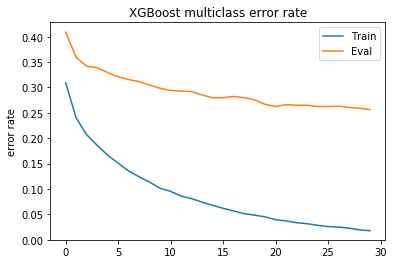

In [36]:
train_stats={}
num_round = 30
evallist = [(dval, 'eval'), (dtrain, 'train')]
params = {
    "booster":'gbtree',
    "max_depth": 6,
    "eta": 0.3,
    "objective":"multi:softmax",
    "num_class":len(train['category'].unique()),
    'eval_metric':['merror']
}
bst = xgboost.train(params, dtrain, num_round, evallist, evals_result=train_stats)
plotResults(train_stats)

the model is showing low training error but high validation error, likely caused by overfitting. Let's reduce the complexity of the model to see if we can decrease this behavior. 

In [49]:
num_round = 30
train_stats={}
params = {
    "booster":'gbtree',
    "max_depth": 6,
    "eta": 0.3,
    "gamma": 1,
    "objective":"multi:softmax",
    "num_class":len(train['category'].unique())
    
}
bst = xgboost.train(params, dtrain, num_round, evallist, evals_result=train_stats)
plotResults(train_stats)

[0]	eval-merror:0.41867	train-merror:0.30667
[1]	eval-merror:0.39118	train-merror:0.23913
[2]	eval-merror:0.36884	train-merror:0.20899
[3]	eval-merror:0.36083	train-merror:0.18609
[4]	eval-merror:0.35052	train-merror:0.16710
[5]	eval-merror:0.34192	train-merror:0.15377
[6]	eval-merror:0.33276	train-merror:0.14130
[7]	eval-merror:0.32532	train-merror:0.12812
[8]	eval-merror:0.32016	train-merror:0.11739
[9]	eval-merror:0.31558	train-merror:0.10884
[10]	eval-merror:0.30928	train-merror:0.10029
[11]	eval-merror:0.30527	train-merror:0.08971
[12]	eval-merror:0.29782	train-merror:0.08275
[13]	eval-merror:0.29840	train-merror:0.07623
[14]	eval-merror:0.29324	train-merror:0.07130
[15]	eval-merror:0.28751	train-merror:0.06464
[16]	eval-merror:0.28580	train-merror:0.06116
[17]	eval-merror:0.28293	train-merror:0.05754
[18]	eval-merror:0.27778	train-merror:0.05275
[19]	eval-merror:0.28236	train-merror:0.04870
[20]	eval-merror:0.27720	train-merror:0.04623
[21]	eval-merror:0.27549	train-merror:0.0437

Increasing the gamma but keeping the tree relatively deep doesn't seem to provide much benefit to the validation error.

[0]	eval-merror:0.43413	train-merror:0.33696
[1]	eval-merror:0.39290	train-merror:0.27290
[2]	eval-merror:0.37514	train-merror:0.23957
[3]	eval-merror:0.36942	train-merror:0.21406
[4]	eval-merror:0.35281	train-merror:0.19594
[5]	eval-merror:0.34421	train-merror:0.17899
[6]	eval-merror:0.33849	train-merror:0.16493
[7]	eval-merror:0.32875	train-merror:0.15145
[8]	eval-merror:0.31615	train-merror:0.14058
[9]	eval-merror:0.31329	train-merror:0.13087
[10]	eval-merror:0.30871	train-merror:0.12232
[11]	eval-merror:0.30355	train-merror:0.11275
[12]	eval-merror:0.30183	train-merror:0.10333
[13]	eval-merror:0.30012	train-merror:0.09348
[14]	eval-merror:0.29439	train-merror:0.08536
[15]	eval-merror:0.29038	train-merror:0.08073
[16]	eval-merror:0.28809	train-merror:0.07507
[17]	eval-merror:0.28408	train-merror:0.07029
[18]	eval-merror:0.28236	train-merror:0.06565
[19]	eval-merror:0.28007	train-merror:0.06058
[20]	eval-merror:0.28236	train-merror:0.05594
[21]	eval-merror:0.28121	train-merror:0.0518

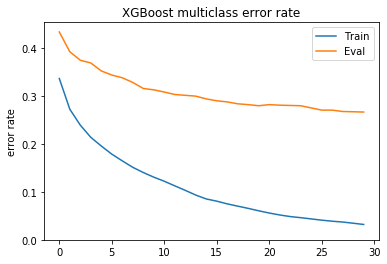

In [50]:
num_round = 30
train_stats={}
params = {
    "booster":'gbtree',
    "max_depth": 6,
    "eta": 0.3,
    "objective":"multi:softmax",
    "num_class":len(train['category'].unique()),
    "min_child_weight":3
}
bst = xgboost.train(params, dtrain, num_round, evallist, evals_result=train_stats)
plotResults(train_stats)

Incresaing another parameter that regulates further tree partitioning behavior does not seem to help either.

[0]	eval-merror:0.48167	train-merror:0.42290
[1]	eval-merror:0.42898	train-merror:0.36985
[2]	eval-merror:0.41695	train-merror:0.34275
[3]	eval-merror:0.39404	train-merror:0.32348
[4]	eval-merror:0.38488	train-merror:0.30826
[5]	eval-merror:0.37629	train-merror:0.29464
[6]	eval-merror:0.36655	train-merror:0.28304
[7]	eval-merror:0.36197	train-merror:0.27377
[8]	eval-merror:0.35052	train-merror:0.26420
[9]	eval-merror:0.34708	train-merror:0.25406
[10]	eval-merror:0.34421	train-merror:0.24985
[11]	eval-merror:0.33333	train-merror:0.24116
[12]	eval-merror:0.32875	train-merror:0.23333
[13]	eval-merror:0.32532	train-merror:0.22551
[14]	eval-merror:0.31558	train-merror:0.21783
[15]	eval-merror:0.31443	train-merror:0.20826
[16]	eval-merror:0.30699	train-merror:0.20116
[17]	eval-merror:0.30298	train-merror:0.19391
[18]	eval-merror:0.29611	train-merror:0.18913
[19]	eval-merror:0.29381	train-merror:0.18391
[20]	eval-merror:0.28751	train-merror:0.17985
[21]	eval-merror:0.28637	train-merror:0.1723

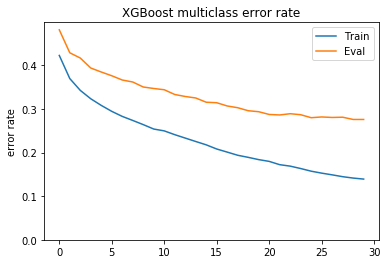

In [51]:
num_round = 30
train_stats={}
params = {
    "booster":'gbtree',
    "max_depth": 3,
    "eta": 0.3,
    "objective":"multi:softmax",
    "num_class":len(train['category'].unique())
}
bst = xgboost.train(params, dtrain, num_round, evallist, evals_result=train_stats)
plotResults(train_stats)

Decreasing the tree size seems to help decrease the gap between train error and evaluation error, which is positive since it will likely lead to less overfitting. On the other hand, it looks like the model could benefit from more round as the training error was still decreasing at iteration #30

[0]	eval-merror:0.48167	train-merror:0.42290
[1]	eval-merror:0.44731	train-merror:0.39275
[2]	eval-merror:0.43814	train-merror:0.37449
[3]	eval-merror:0.42383	train-merror:0.36681
[4]	eval-merror:0.41581	train-merror:0.35710
[5]	eval-merror:0.41008	train-merror:0.35246
[6]	eval-merror:0.40722	train-merror:0.35116
[7]	eval-merror:0.40206	train-merror:0.34087
[8]	eval-merror:0.39462	train-merror:0.33536
[9]	eval-merror:0.39003	train-merror:0.33261
[10]	eval-merror:0.38660	train-merror:0.32696
[11]	eval-merror:0.38316	train-merror:0.32246
[12]	eval-merror:0.38144	train-merror:0.31594
[13]	eval-merror:0.37972	train-merror:0.31246
[14]	eval-merror:0.37801	train-merror:0.30667
[15]	eval-merror:0.37514	train-merror:0.30377
[16]	eval-merror:0.37285	train-merror:0.29725
[17]	eval-merror:0.36999	train-merror:0.29507
[18]	eval-merror:0.36598	train-merror:0.29275
[19]	eval-merror:0.36541	train-merror:0.28870
[20]	eval-merror:0.36426	train-merror:0.28609
[21]	eval-merror:0.36197	train-merror:0.2844

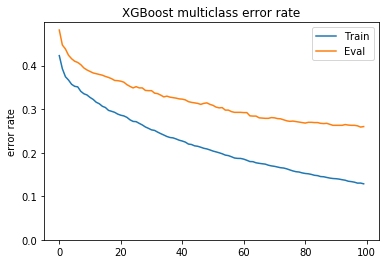

In [54]:
num_round = 100
train_stats={}
params = {
    "booster":'gbtree',
    "max_depth": 3,
    "eta": 0.1,
    "objective":"multi:softmax",
    "num_class":len(train['category'].unique())
}
bst = xgboost.train(params, dtrain, num_round, evallist, evals_result=train_stats)
plotResults(train_stats)

Reducing learning rate also helps decrease the gap between trainign and evaluation error. On the flip side, the model will require more rounds to minimize training and evaluation error.

[0]	eval-merror:0.44332	train-merror:0.42769
[1]	eval-merror:0.41885	train-merror:0.39971
[2]	eval-merror:0.40812	train-merror:0.38207
[3]	eval-merror:0.39737	train-merror:0.37088
[4]	eval-merror:0.38305	train-merror:0.36040
[5]	eval-merror:0.37232	train-merror:0.35395
[6]	eval-merror:0.36873	train-merror:0.34993
[7]	eval-merror:0.36695	train-merror:0.34247
[8]	eval-merror:0.36396	train-merror:0.33659
[9]	eval-merror:0.35919	train-merror:0.33027
[10]	eval-merror:0.35382	train-merror:0.32726
[11]	eval-merror:0.35859	train-merror:0.32109
[12]	eval-merror:0.35322	train-merror:0.31478
[13]	eval-merror:0.35024	train-merror:0.30947
[14]	eval-merror:0.35143	train-merror:0.30617
[15]	eval-merror:0.34069	train-merror:0.30144
[16]	eval-merror:0.33890	train-merror:0.29727
[17]	eval-merror:0.33771	train-merror:0.29656
[18]	eval-merror:0.33890	train-merror:0.29369
[19]	eval-merror:0.33771	train-merror:0.29039
[20]	eval-merror:0.33831	train-merror:0.28651
[21]	eval-merror:0.33771	train-merror:0.2843

[177]	eval-merror:0.24821	train-merror:0.06600
[178]	eval-merror:0.24881	train-merror:0.06600
[179]	eval-merror:0.24940	train-merror:0.06614
[180]	eval-merror:0.25000	train-merror:0.06600
[181]	eval-merror:0.25060	train-merror:0.06542
[182]	eval-merror:0.25060	train-merror:0.06499
[183]	eval-merror:0.25060	train-merror:0.06471
[184]	eval-merror:0.24940	train-merror:0.06413
[185]	eval-merror:0.25060	train-merror:0.06399
[186]	eval-merror:0.24940	train-merror:0.06399
[187]	eval-merror:0.24702	train-merror:0.06327
[188]	eval-merror:0.24702	train-merror:0.06270
[189]	eval-merror:0.24702	train-merror:0.06255
[190]	eval-merror:0.24582	train-merror:0.06227
[191]	eval-merror:0.24642	train-merror:0.06198
[192]	eval-merror:0.24403	train-merror:0.06169
[193]	eval-merror:0.24523	train-merror:0.06083
[194]	eval-merror:0.24403	train-merror:0.06069
[195]	eval-merror:0.24344	train-merror:0.05940
[196]	eval-merror:0.24344	train-merror:0.05954
[197]	eval-merror:0.24224	train-merror:0.05911
[198]	eval-me

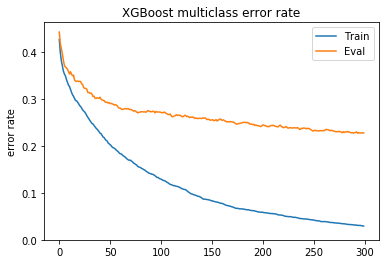

In [37]:
num_round = 300
train_stats={}
params = {
    "booster":'gbtree',
    "max_depth": 3,
    "eta": 0.1,
    "objective":"multi:softmax",
    "num_class":len(train['category'].unique())
}
bst = xgboost.train(params, dtrain, num_round, evallist, evals_result=train_stats)
plotResults(train_stats)

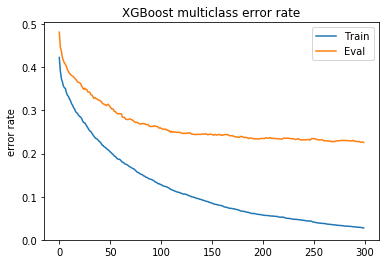

In [56]:
plotResults(train_stats)

With 300 iterations and a learning rate of 0.1, we notice that the training error is minimal and the evaluation error plateaus around 0.23. This is probably as good as it gets with the current features.

### Gradient Boosted Trees - Evaluation

Let's check the performance of the final gradient boosted tree model against our evaluation metrics.

In [43]:
pred = bst.predict(dval)

In [44]:
accuracy_score(y_val_xg, pred)

0.7720763723150358

In [39]:
confusion_matrix(y_val_xg, pred)

array([[ 62,   1,   7,   3,   1,   2,   2,   1,   0,   1,   0,   2],
       [  0,  68,   2,   9,   2,   4,   4,   5,   1,   0,   2,   3],
       [  3,   2, 104,  13,  11,   1,   1,   0,   0,   1,   4,   2],
       [  1,   5,   9, 227,   5,   3,   2,   1,   0,   2,  15,   1],
       [  3,   0,  13,   9, 128,   1,   2,   0,   5,   1,   5,   1],
       [  0,   3,   1,   5,   0,  79,   3,   0,   1,   6,   0,   1],
       [  2,   2,   0,  14,   6,   3,  87,   2,   7,   2,   2,   3],
       [  0,   9,   2,   9,   0,   6,   4,  36,   0,   5,   0,   0],
       [  1,   1,   0,   4,   4,   1,   9,   0,  70,   3,   2,   0],
       [  0,   1,   3,   5,   2,   0,   8,   3,   0, 183,   0,   0],
       [  0,   3,   2,  16,   1,   0,   8,   1,   4,   1, 169,   0],
       [  0,   0,   3,  17,   2,   0,   1,   1,   0,   2,   1,  81]])

In [41]:
f1_score(y_val_xg, pred, average='weighted')

0.7715005669535813

Xgboost performs better than the KNN model by around 15% in both accuracy and weighted F-1 score. Even if it seems logical to pick the gradient boosted tree model for future classification tasks, in practice it might make sense to trade accuracy for the increased transparency, explainability, and ease of deployment of the simpler model.